# Predicting Match Outcomes in Dota 2



- Student Name: John Casey Dean
- Student Pace: Part Time
- Scheduled Review: 1-8-2021 16:30 CT
- Instructor Name: Lindsey Berlin
- Blog Post URL: 

# Introduction

For the better part of two decades, online multiplayer video games have been accruing massive player bases and forming competitive environments within them. These games span many different genres, and range from simple enough for children to complex enough to require thousands of hours of playtime to develop high level skills. 

One such game is Dota 2, created by Valve Software. Launched in 2012, this game has maintained a strong following all the way to the present day, where there are at least 400,000 players online at any point in time. Given the stability of the player base, it's not surprising that it also enjoys a strong competitive scene, creating myriad opportunities for individuals to generate income from the game. It has also generated an appetite for strong predictive tools that allow for more confident analysis and betting predictions.

This project seeks to develop a strong predictive model for win probabilities of two teams, using only what is known prior to the start of a match.

# Obtaining Data

This project uses data sourced from OpenDota, an open source community project that parses match data from Steam and provided the parsed match data to users. You can find the OpenDota project here: https://www.opendota.com/ 

Using their API, we pulled nearly 32,000 random matches from January 1, 2021, to January 4, 2021, and used them to build our models.

# Scrubbing the Data

The data we obtained contains everything we need to make a minimum viable product, but the formatting is incovenient for exploration and modeling. Before moving on, the data will need to be reformatted.

## Importing Necessary Libraries and Data

In [1]:
import pandas as pd
import seaborn as sns
import requests
import json
import sklearn
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from project_funcs import add_hero_cols, plot_conf_matrix, plot_roc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix,roc_curve, confusion_matrix 
from sklearn.metrics import plot_roc_curve, roc_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
import pickle

In [2]:
df = pd.read_csv('match_data.csv')
df.head()

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster,radiant_team,dire_team
0,5774382508,4861536209,True,1609928270,567,4902.0,6.0,7,3,79,8,236,"81,62,41,39,31","95,8,1,129,109"
1,5774380902,4861534174,True,1609928176,448,NaN,NaN,0,22,25,3,184,"18,2,21,37,84","62,13,35,41,4"
2,5774380304,4861533616,True,1609928140,474,3978.0,1.0,0,22,54,3,187,"30,123,65,70,50","42,19,59,90,86"
3,5774378001,4861541478,False,1609928009,1192,NaN,NaN,0,22,27,3,134,"93,74,120,42,52","121,99,77,21,101"
4,5774376916,4861542219,False,1609927939,1312,2531.0,2.0,0,4,42,5,137,"44,30,17,8,110","35,75,32,59,27"


In [3]:
df.isna().sum()

match_id            0
match_seq_num       0
radiant_win         0
start_time          0
duration            0
avg_mmr          7087
num_mmr          7087
lobby_type          0
game_mode           0
avg_rank_tier       0
num_rank_tier       0
cluster             0
radiant_team        0
dire_team           0
dtype: int64

In [4]:
df.shape

(31934, 14)

In [5]:
df['lobby_type'].value_counts()

7    25783
0     6151
Name: lobby_type, dtype: int64

In [6]:
df['game_mode'].value_counts()

22    26954
3      2643
4      2307
5        30
Name: game_mode, dtype: int64

In [7]:
df['num_mmr'].value_counts()

1.0    7777
2.0    7065
3.0    5386
4.0    2814
5.0    1158
6.0     555
7.0      92
Name: num_mmr, dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.isna().sum()

match_id         0
match_seq_num    0
radiant_win      0
start_time       0
duration         0
avg_mmr          0
num_mmr          0
lobby_type       0
game_mode        0
avg_rank_tier    0
num_rank_tier    0
cluster          0
radiant_team     0
dire_team        0
dtype: int64

In [10]:
df2 = add_hero_cols(df, 'radiant_team')
df2 = add_hero_cols(df, 'dire_team')
df2.head()

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,...,Winter Wyvern_dire_team,Arc Warden_dire_team,Monkey King_dire_team,Dark Willow_dire_team,Pangolier_dire_team,Grimstroke_dire_team,Hoodwink_dire_team,Void Spirit_dire_team,Snapfire_dire_team,Mars_dire_team
0,5774382508,4861536209,True,1609928270,567,4902.0,6.0,7,3,79,...,0,0,0,0,0,0,0,0,0,1
2,5774380304,4861533616,True,1609928140,474,3978.0,1.0,0,22,54,...,0,0,0,0,0,0,0,0,0,0
4,5774376916,4861542219,False,1609927939,1312,2531.0,2.0,0,4,42,...,0,0,0,0,0,0,0,0,0,0
5,5774376511,4861538645,True,1609927915,1070,2362.0,3.0,7,22,53,...,0,0,0,0,0,0,0,0,0,0
6,5774375502,4861539678,True,1609927840,1247,3593.0,1.0,7,22,32,...,0,0,0,0,0,1,0,0,0,0


In [11]:
df2.drop(['match_id', 'match_seq_num', 'start_time', 'duration', 'num_mmr',
          'lobby_type', 'game_mode', 'avg_rank_tier', 'num_rank_tier', 'cluster'], 
         axis = 1, inplace = True)
df2.head()

,radiant_win,avg_mmr,Anti-Mage_radiant_team,Axe_radiant_team,Bane_radiant_team,Bloodseeker_radiant_team,Crystal Maiden_radiant_team,Drow Ranger_radiant_team,Earthshaker_radiant_team,Juggernaut_radiant_team,...,Winter Wyvern_dire_team,Arc Warden_dire_team,Monkey King_dire_team,Dark Willow_dire_team,Pangolier_dire_team,Grimstroke_dire_team,Hoodwink_dire_team,Void Spirit_dire_team,Snapfire_dire_team,Mars_dire_team
0,True,4902.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,True,3978.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,2531.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,True,2362.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,True,3593.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [12]:
df2.to_csv('sparse_table.csv', index = False)

In [13]:
df2['radiant_win'].sum()

15333

# Exploratory Data Analysis

# Modeling

The first model we will create is a simple logistic regression model. This will give us a baseline to compare other models to. We will then explore other models, including boosting and parameter tuning packages. 

Before actually modeling, we have a single column that outscales the others drastically; the avg_mmr feature. In order to avoid overtuning to this feature, we will quickly scale it down between 0 and 1 to be in line with our sparse table.

In [14]:
mmr_max = df2['avg_mmr'].max()

In [15]:
df2['avg_mmr'] = df2['avg_mmr']/mmr_max
df2.head()

,radiant_win,avg_mmr,Anti-Mage_radiant_team,Axe_radiant_team,Bane_radiant_team,Bloodseeker_radiant_team,Crystal Maiden_radiant_team,Drow Ranger_radiant_team,Earthshaker_radiant_team,Juggernaut_radiant_team,...,Winter Wyvern_dire_team,Arc Warden_dire_team,Monkey King_dire_team,Dark Willow_dire_team,Pangolier_dire_team,Grimstroke_dire_team,Hoodwink_dire_team,Void Spirit_dire_team,Snapfire_dire_team,Mars_dire_team
0,True,0.750000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,True,0.608629,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,0.387240,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,True,0.361383,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,True,0.549725,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


<AxesSubplot:xlabel='avg_mmr'>

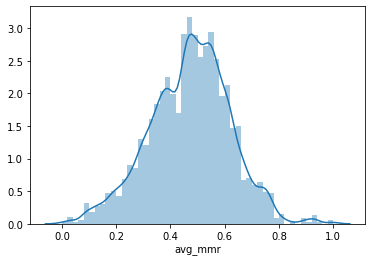

In [16]:
sns.distplot(df2['avg_mmr'])

In [17]:
i=1
for col in df2.columns:
    print(i-1, col)
    i+=1

0 radiant_win
1 avg_mmr
2 Anti-Mage_radiant_team
3 Axe_radiant_team
4 Bane_radiant_team
5 Bloodseeker_radiant_team
6 Crystal Maiden_radiant_team
7 Drow Ranger_radiant_team
8 Earthshaker_radiant_team
9 Juggernaut_radiant_team
10 Mirana_radiant_team
11 Morphling_radiant_team
12 Shadow Fiend_radiant_team
13 Phantom Lancer_radiant_team
14 Puck_radiant_team
15 Pudge_radiant_team
16 Razor_radiant_team
17 Sand King_radiant_team
18 Storm Spirit_radiant_team
19 Sven_radiant_team
20 Tiny_radiant_team
21 Vengeful Spirit_radiant_team
22 Windranger_radiant_team
23 Zeus_radiant_team
24 Kunkka_radiant_team
25 Lina_radiant_team
26 Lion_radiant_team
27 Shadow Shaman_radiant_team
28 Slardar_radiant_team
29 Tidehunter_radiant_team
30 Witch Doctor_radiant_team
31 Lich_radiant_team
32 Riki_radiant_team
33 Enigma_radiant_team
34 Tinker_radiant_team
35 Sniper_radiant_team
36 Necrophos_radiant_team
37 Warlock_radiant_team
38 Beastmaster_radiant_team
39 Queen of Pain_radiant_team
40 Venomancer_radiant_team
41 

In [18]:
state = 117

In [19]:
# Separating our features from our target
df2_x = df2.drop(columns=['radiant_win'], axis = 1)
df2_y = df2['radiant_win']

In [20]:
# Generating training and testing data
x_train, x_test, y_train, y_test = train_test_split(df2_x, df2_y, test_size = 0.25, random_state=state)

## Logistic Regression

In [21]:
# Instantiating our estimator object
logreg = LogisticRegression(max_iter = 200, random_state = state, solver ='lbfgs',  n_jobs=-1)

In [22]:
# Fitting our model
logreg.fit(x_train, y_train)

LogisticRegression(max_iter=200, n_jobs=-1, random_state=117)

In [23]:
# Generating our predictions
lr_predictions = logreg.predict(x_test)

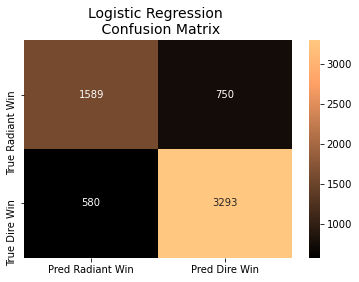

In [24]:
# Generate an plot our confusion matrix
plot_conf_matrix('Logistic Regression', lr_predictions, y_test)

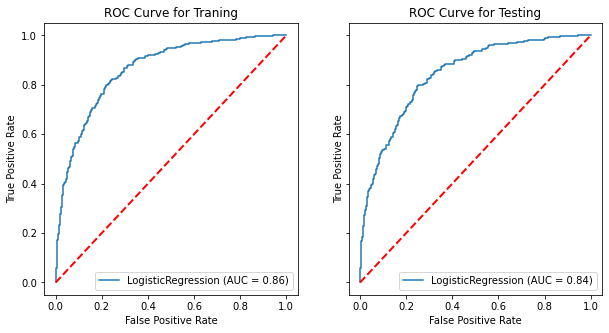

In [25]:
plot_roc(logreg, x_train, y_train, x_test, y_test)

## Random Forest Classifier

In [26]:
# Instantiating our estimator object
rfc = RandomForestClassifier(criterion='entropy',
                             min_samples_split=.1,
                             random_state=state,
                             n_jobs=-1)

In [27]:
rfc.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=0.1, n_jobs=-1,
                       random_state=117)

In [28]:
rfc_y_pred = rfc.predict(x_test)

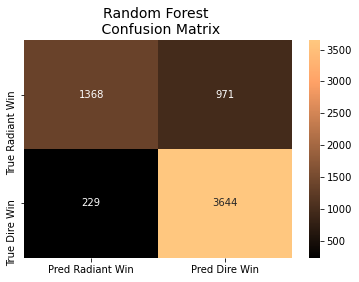

In [29]:
# Generate an plot our confusion matrix
plot_conf_matrix('Random Forest', rfc_y_pred, y_test)

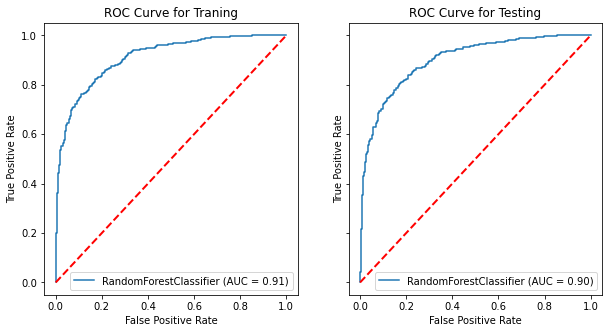

In [30]:
plot_roc(rfc, x_train, y_train, x_test, y_test)

## GridsearchCV

In [31]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__criterion' : ['entropy'],
    'classifier__min_samples_split' : [0.1, .01, .001],
    'classifier__max_features' : ['auto', 'sqrt', 'log2']
    }
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   16.8s finished


In [32]:
gs_preds = best_clf.predict(x_test)

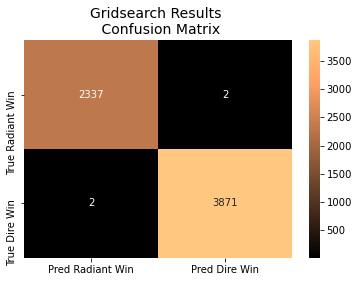

In [33]:
# Generate an plot our confusion matrix
plot_conf_matrix('Gridsearch Results', gs_preds, y_test)

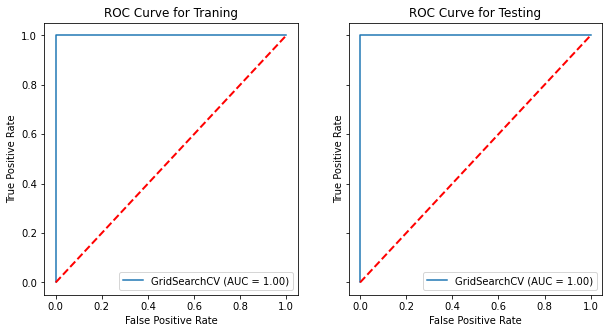

In [34]:
plot_roc(best_clf, x_train, y_train, x_test, y_test)

In [35]:
best_clf.best_params_

{'classifier': RandomForestClassifier(criterion='entropy', min_samples_split=0.001),
 'classifier__criterion': 'entropy',
 'classifier__max_features': 'auto',
 'classifier__min_samples_split': 0.001}

In [36]:
best_reg = RandomForestClassifier(criterion='entropy', 
                                  min_samples_split=0.001, 
                                  random_state = state, 
                                  n_jobs=-1)

In [37]:
final_clf = best_reg.fit(df2_x, df2_y)

# Future Work